<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/ase3001_exercises_numerical_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical simulation

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_
_<div style="text-align: right"> Seungyeop Lee (seungyeoplee@inha.edu) </div>_
_<div style="text-align: right"> Hyejin Park (hyejinPark@inha.edu) </div>_

<br>

---

## Dynamic model

A "system" is defined as an entity that generates an output in response to a given input, and the "state" of the system represents its condition at a specific point in time. The rule that determines how the state changes over time is called as the "dynamics" of the system.

In continuous time, the dynamics are typically described by a differential equation of the form

$$
\dot{x}(t) = f(x(t), u(t), t),
$$

where $u(t)$ denotes the "input" to the system. In a time-invariant system, the function $f$ is independent of time $t$, whereas in a time-varying system, $f$ explicitly depends on $t$ as shown in above example.

"Numerical simulation" is the process of solving this differential equation, given an initial state $x_0$, in order to compute the trajectory of the state over time $t$.

<br>

---

## Numerical Integration

In numerical simulation, in addition to the system dynamics, a crucial component is "integration".
Integration can be performed analytically in some cases, but in "numerical integration", the time domain is discretized into a finite set of points, and the state is updated sequentially over these small time intervals.

Formally, consider a continuous-time system with dynamics

$$
\dot{x}(t) = f(x(t), u(t), t), \quad x(t_0) = x_0.
$$

To perform numerical integration, we discretize time into steps $t_0, t_1, \dots, t_N$ with a uniform step size $\Delta t = t_{k+1} - t_k$, and approximate the state evolution sequentially:

$$
x_{k+1} \approx x_k + \int_{t_k}^{t_{k+1}} f(x(t), u(t), t)\, dt.
$$

Several intuitive and widely used numerical integration methods exist. Among the simplest are "Euler integration" and "trapezoidal integration" (also called the "trapezoidal rule").

* "Euler integration" updates the state as

$$
x_{k+1} = x_k + \Delta t \, f(x_k, u_k, t_k).
$$

* "Trapezoidal integration" improves accuracy by using the average slope over the interval:

$$
x_{k+1} = x_k + \frac{\Delta t}{2} \big( f(x_k, u_k, t_k) + f(x_{k+1}, u_{k+1}, t_{k+1}) \big).
$$

These methods provide simple yet effective approaches to approximate the evolution of continuous-time dynamics in a "discrete-time framework", which is essential for simulation and control design.


<br>

---

## Numerical Simulation Example : Satellite Orbit Propagation

We now illustrate the use of "Euler integration" and "trapezoidal integration" to numerically propagate a satellite’s orbit around Earth for example.

#### 1. Satellite State Definition

The satellite "state vector" is defined as

$$
x =
\begin{bmatrix}
\mathbf{r} \\
\mathbf{v} \\
\mathbf{q} \\
\boldsymbol{\omega}
\end{bmatrix}
\in \mathbb{R}^{13}
$$

where

- $\mathbf{r} = (x, y, z)$ is the position in inertial coordinates (meters),
- $\mathbf{v} = (v_x, v_y, v_z)$ is the velocity (m/s),
- $\mathbf{q} = (q_x, q_y, q_z, q_w)$ is the attitude quaternion,
- $\boldsymbol{\omega} = (\omega_x, \omega_y, \omega_z)$ is the angular velocity (rad/s) in the body frame.

#### 2. Satellite Dynamics

The dynamics of the satellite are given by:

$$
\begin{align*}
\dot{\mathbf{r}} &= \mathbf{v}, \\
\dot{\mathbf{v}} &= - \frac{\mu}{r^3} \mathbf{r}, \\
\dot{\mathbf{q}} &= \frac{1}{2} \mathbf{\Omega}(\boldsymbol{\omega}) \mathbf{q}, \\
\dot{\boldsymbol{\omega}} &= \mathbf{J}^{-1} \left( \mathbf{\tau} - \boldsymbol{\omega} \times (\mathbf{J} \boldsymbol{\omega}) \right),
\end{align*}
$$

where

- $\mu = 3.986\times10^{14}\,\text{m}^3/\text{s}^2$ is Earth’s gravitational parameter,
- $r = \|\mathbf{r}\|$ is the radial distance from Earth’s center,
- $\mathbf{\Omega}(\boldsymbol{\omega})$ is the quaternion kinematics matrix(this will be given in code),
- $\mathbf{J} = \text{diag}(100, 120, 80)\,\text{kg·m²}$ is the inertia matrix,
- $\mathbf{\tau} = \mathbf{0}$ (no external torque).

#### 3. Initial State

We set the initial state as:

$$
x_0 =
\begin{bmatrix}
x_0 & y_0 & z_0 &
v_{x0} & v_{y0} & v_{z0} &
q_x & q_y & q_z & q_w &
\omega_x & \omega_y & \omega_z
\end{bmatrix}^T\\
=
\begin{bmatrix}
7000\times10^3& 0& 0 &
0& 7.546& 0 &
0& 0& 0& 1 &
0& 0& 0
\end{bmatrix}^T.
$$

- The satellite is initially at an altitude of 700 km along the x-axis, moving tangentially along the y-axis to maintain a circular orbit.
- No initial rotation is assumed.

<br>

---

_**(Problem 1)**_ Now, implement both "Euler integration" and "trapezoidal integration" to propagate the satellite state from the initial time $t=0$ to the orbital period $T = 2\pi \sqrt{r^3/\mu} \approx 5,832\ \text{s}$.

The satellite’s **initial state** is given as $x_0$, and the state is propagated using different time steps:

$$
\Delta t = \{1\,\text{s}, 10\,\text{s}, 60\,\text{s}\}.
$$

Compute for each integration method, and each time steps. You have to yield these six trajectories:

1. Euler integration with $\Delta t = 1\,\text{s}$
2. Euler integration with $\Delta t = 10\,\text{s}$
3. Euler integration with $\Delta t = 60\,\text{s}$
4. Trapezoidal integration with $\Delta t = 1\,\text{s}$
5. Trapezoidal integration with $\Delta t = 10\,\text{s}$
6. Trapezoidal integration with $\Delta t = 60\,\text{s}$

**Personalized step size (by student ID).** In addition to the six cases above, each student must also run **both** integration methods with an individualized step size

$$
\Delta t_\text{personal} =
\begin{cases}
\frac{d}{10} \ \text{s}, & \text{if } d \in \{1,\dots,9\} \text{ is the last digit of your student ID},\\[2pt]
0.01\ \text{s}, & \text{if the last digit } d=0\,.
\end{cases}
$$

Examples: if your ID ends with 7, use $\Delta t=0.7\,\text{s}$; if it ends with 0, use $\Delta t=0.01\,\text{s}$.

7. Euler integration with $\Delta t = \Delta t_\text{personal}$
8. Trapezoidal integration with $\Delta t = \Delta t_\text{personal}$


In [4]:
import numpy              as np
import numpy.linalg       as nl
import matplotlib.pyplot  as plt

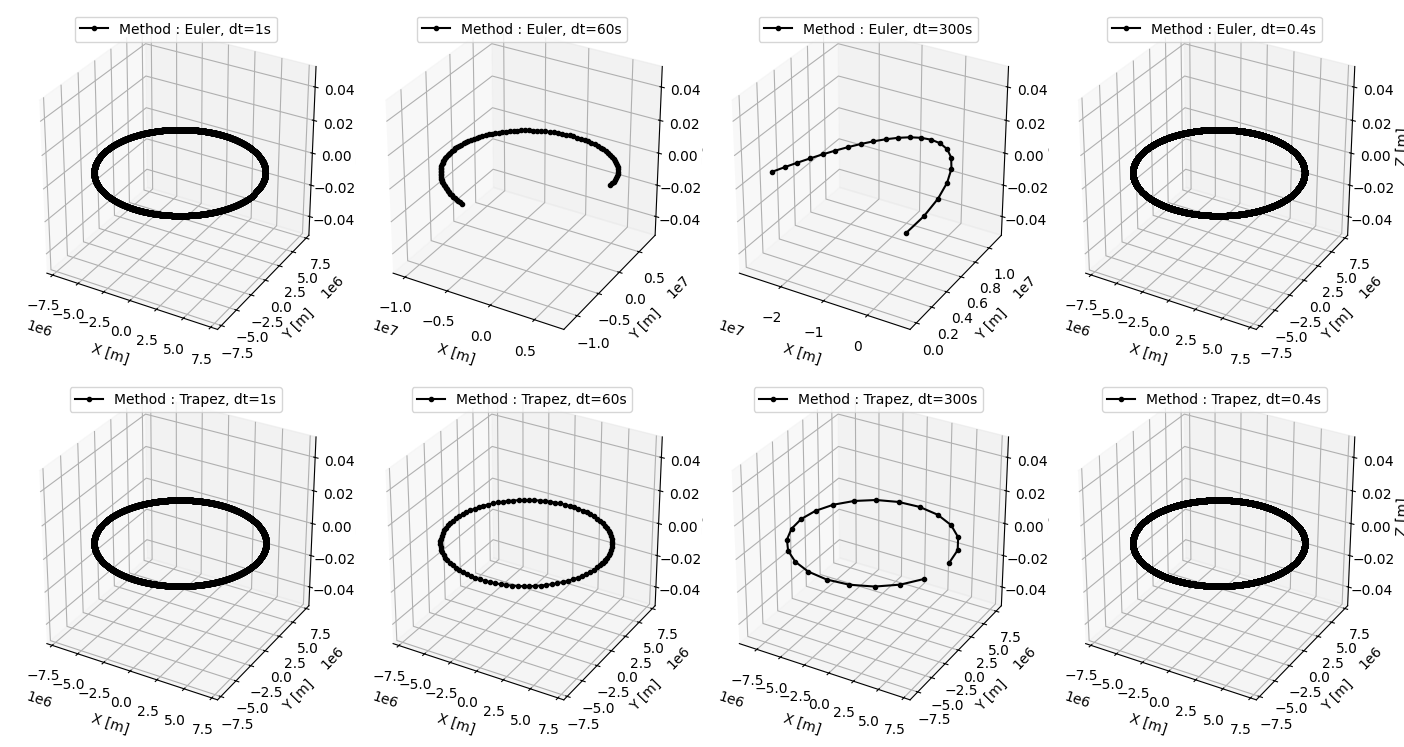

In [56]:
### Parameters                # Descriptions                        # Units
mu = 3.986e14                 # Earth's gravitational parameter     [m^3/s^2]
J  = np.diag([100, 120, 80])  # Satellite inertia matrix            [kg·m²]
J_inv = np.linalg.inv(J)
T  = 5832                     # Orbital period                      [s]
r0 = 7000e3                   # Initial orbital radius              [m]
v0 = np.sqrt(mu / r0)         # Circular orbit velocity             [m/s]



### Initial state
x0 = np.array([
    r0, 0, 0,       # position
    0, v0, 0,       # velocity
    0, 0, 0, 1,     # quaternion
    0, 0, 0         # angular velocity
])

### Dynamics
# Rotation kinematics
def Omega(w):
    wx, wy, wz = w
    return np.array([
        [0,  -wx, -wy, -wz],
        [wx,   0,  wz, -wy],
        [wy, -wz,   0,  wx],
        [wz,  wy, -wx,   0]
    ])

# Dynamics model f(x)#################

############your code here############

def der_x(x,t = None):
  r = x[:3]
  v = x[3:6]
  q = x[6:10]
  w = x[10:]
  r_norm = np.linalg.norm(r)
  omega = Omega(w)
  #der
  r_dot = v
  v_dot = -mu/(r_norm**3) * r
  q_dot = 1/2 * omega @ q
  w_dot = J_inv@( - np.cross(w, J @w ))
  return np.concatenate((r_dot, v_dot,q_dot,w_dot))

def euler(x,dt):
 x_next = x + dt * der_x(x)
 return x_next
def trap(x,dt):
  x_next_first = euler(x,dt)
  x_next=  x + dt/2 * (der_x(x) + der_x(x_next_first))
  return x_next

def inter(x0,dt,method,terminal_time):
  X = np.zeros_like(x0)
  X = X.reshape(1,len(X))
  X[0] = x0
  for i in range(0,int(terminal_time/dt)+2):
    if method == "e":
      X_next = euler(X[-1],dt)
      X = np.vstack((X,X_next))
    else:
      X_next = trap(X[-1],dt)
      X = np.vstack((X,X_next))
  return X

methods = ["e","t"]
dts = [1,60,300, 0.4]
name_map = {'e': 'Euler', 't': 'Trapez'}

from mpl_toolkits.mplot3d import Axes3D
fig, axes = plt.subplots(len(methods), len(dts),
                         subplot_kw={'projection': '3d'},
                         figsize=(14, 8))
for i, method in enumerate(methods):
    for j, dt in enumerate(dts):
        ax = axes[i, j]
        X = inter(x0, dt, method, T)   # or 5832 동일
        x, y, z = X[:, 0], X[:, 1], X[:, 2]

        ax.plot(x, y, z, 'k.-', label=f"Method : {name_map[method]}, dt={dt}s")
        ax.legend(loc='upper center', frameon=True)

        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")
        ax.set_zlabel("Z [m]")
        try:
            ax.set_box_aspect([1, 1, 1])  # 가능하면 정비율
        except Exception:
            pass

plt.tight_layout()
plt.show()

######################################


<br>

---

## Runge–Kutta Integration

As observed in the previous example, as the time step $\Delta t$ increases, both Euler and trapezoidal integration accumulate errors, resulting in inaccurate trajectories.

However, it is not always feasible to reduce $\Delta t$ arbitrarily to improve accuracy, because a smaller $\Delta t$ requires a larger number of time steps, which increases computational cost.

To address this, "Runge–Kutta (RK) integration" can be employed. RK methods provide higher accuracy than the previously introduced integration techniques, allowing relatively small errors even with larger $\Delta t$.

Runge–Kutta methods are classified by their order, such as RK4, RK5, etc., according to the order of accuracy. The most commonly used fourth-order method, RK4, is defined as follows:

$$
\begin{aligned}
k_1 &= f(x_k, t_k), \\
k_2 &= f\Big(x_k + \frac{\Delta t}{2} k_1, t_k + \frac{\Delta t}{2}\Big), \\
k_3 &= f\Big(x_k + \frac{\Delta t}{2} k_2, t_k + \frac{\Delta t}{2}\Big), \\
k_4 &= f(x_k + \Delta t \, k_3, t_k + \Delta t), \\
x_{k+1} &= x_k + \frac{\Delta t}{6} (k_1 + 2 k_2 + 2 k_3 + k_4)
\end{aligned}
$$

This approach achieves fourth-order accuracy, meaning that the local truncation error is proportional to $(\Delta t)^5$, and the global error scales with $(\Delta t)^4$.

<br>

---

_**(Problem 2)**_ Now, let us implement the fourth-order Runge–Kutta (RK4) method introduced above. And repeat the same simulation with the RK4 integrator you implemented

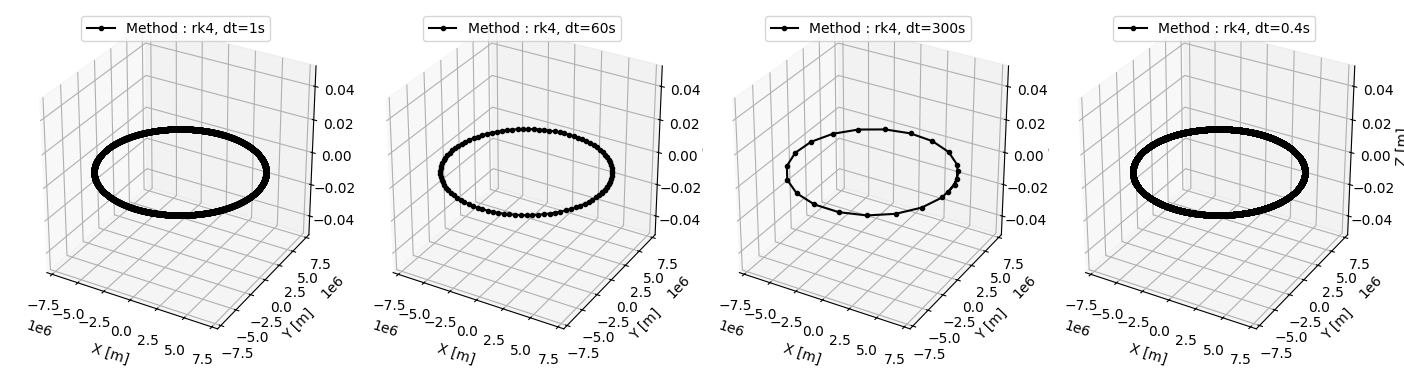

In [57]:
def rk4(x,dt):
  k1 = der_x(x)
  k2 = der_x(x + dt/2 * k1)
  k3 = der_x(x + dt/2 * k2)
  k4 = der_x(x + dt * k3)
  x_next = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
  return x_next

def inter(x0,dt,method,terminal_time):
  X = np.zeros_like(x0)
  X = X.reshape(1,len(X))
  X[0] = x0
  for i in range(0,int(terminal_time/dt)+2):
    if method == "e":
      X_next = euler(X[-1],dt)
      X = np.vstack((X,X_next))
    elif method == "t":
      X_next = trap(X[-1],dt)
      X = np.vstack((X,X_next))
    else:
      X_next = rk4(X[-1],dt)
      X = np.vstack((X,X_next))
  return X

method = ["rk4"]
dts = [1,60,300,0.4]
name_map = {'e': 'Euler', 't': 'Trapez',"rk4": 'RK4'}

from mpl_toolkits.mplot3d import Axes3D
fig, axes = plt.subplots(1, len(dts),
                         subplot_kw={'projection': '3d'},
                         figsize=(14, 8))

for j, dt in enumerate(dts):
    ax = axes[j]
    X = inter(x0, dt, method, T)   # or 5832 동일
    x, y, z = X[:, 0], X[:, 1], X[:, 2]

    ax.plot(x, y, z, 'k.-', label=f"Method : rk4, dt={dt}s")
    ax.legend(loc='upper center', frameon=True)

    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    try:
        ax.set_box_aspect([1, 1, 1])  # 가능하면 정비율
    except Exception:
        pass

plt.tight_layout()
plt.show()


In [58]:
### Simulation


As observed in the results, RK4 integration maintains significantly higher accuracy compared to Euler and trapezoidal methods. Even when the time step $\Delta t$ is increased, RK4 propagates the state with smaller accumulated error, whereas Euler and trapezoidal integration exhibit noticeable deviations in the orbital trajectory.

<br>

---

_**(Problem 3)**_  Practice with a Python ODE Library using `odeint`

Use **SciPy’s `odeint` (LSODA)** to propagate the already-defined dynamics over $[0,\,T]$. Your goal here is to learn the **library workflow**

Compute the following three tasks:

1. **Code & plot(s):** integrate with `odeint` and plot one or two representative signals at the 1-s grid.
2. **Short write-up:** in your own words, explain **how** you called the library (function signature, initial value, time array, parameters), which **options/tolerances** you chose and why, and what **solver diagnostics** you examined. Identify each term/option **from the official documentation** (name it and state what it measures).
3. **Tolerance experiment:** choose **three** different tolerances, rerun, and briefly comment on any observable changes (accuracy/behavior/runtime) using the diagnostics you selected.

look up the SciPy docs, decide which options/diagnostics matter, and justify your choices in the write-up.




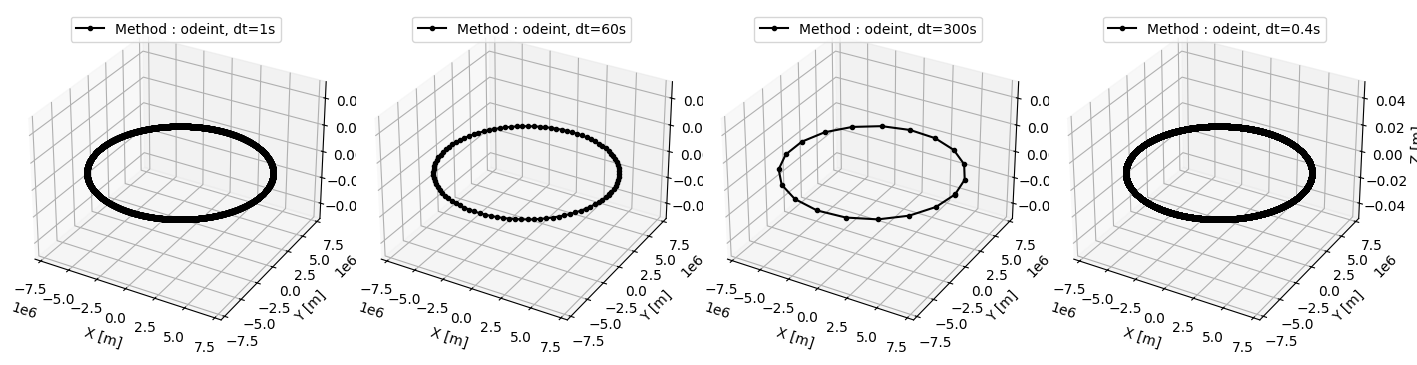

In [62]:
from scipy.integrate import odeint
fig, axes = plt.subplots(1, len(dts),
                         subplot_kw={'projection': '3d'},
                         figsize=(14, 8))

###### your code here ######
for j, dt in enumerate(dts):
  ax = axes[j]
  t = np.linspace(0, T, int(T/dt)+1)
  X = odeint(der_x, x0, t)
  x, y, z = X[:, 0], X[:, 1], X[:, 2]
  ax.plot(x, y, z, 'k.-', label=f"Method : odeint, dt={dt}s")
  ax.legend(loc='upper center', frameon=True)

  ax.set_xlabel("X [m]")
  ax.set_ylabel("Y [m]")
  ax.set_zlabel("Z [m]")
plt.tight_layout()
plt.show()
##IDONTKNOW EVERYTHING